In [4]:
mkdir /kaggle/working/midterm_COVID

mkdir: cannot create directory ‘/kaggle/working/midterm_COVID’: File exists


In [5]:
'''
1.从csv提取到txt
'''
import os
import re
import time
import pandas as pd

# 传参
folderurl = '/kaggle/working/midterm_COVID/'
readcsv = '/kaggle/input/midterm-covid/221012_midterm_COVID_2022-01-01_2022-10-10.csv' # (17690, 9)

writetxt = folderurl + 'test.txt'
youwant=['UserName', 'Embedded_text']

if __name__ == '__main__':
    start = time.time()

    # 1.读取数据
    data = pd.read_csv(readcsv,encoding='utf-8')
    aa = data[youwant[0]].values#<class 'numpy.ndarray'>
    bb = data[youwant[1]].values#<class 'numpy.ndarray'>

    # 2.对文本正则处理
    for i in range(len(bb)):
        c = bb[i].replace('回复', "") # 删除“回复”
        c = re.sub(r"@.*?\s", "", c)  # 删除@后面的人名
        c = re.sub(r"\d?.\d", "", c) # 删除2.1这类数字
        c = re.sub(r"\d","",c) # 删除数字
        c = re.sub(r"[\u4E00-\u9FA5]+", "", c) # 删除中文，\u4E00-\u9FA5\\s的话s不见了
        c = re.sub(r"\n", " ", c)  # 删除换行
        c.strip() # 删除句首和句尾的字符，默认删除空白符和换行符
        bb[i] = c

    # 3.查看写入数据
    print(str(aa[0].rstrip()) + "*****" + str(bb[0].rstrip().lstrip()) + '\n')

    # 4.写入数据
    if not os.path.exists(writetxt):
        os.system(r"touch {}".format(os.path))  # 调用系统命令行来创建文件
    with open(writetxt, 'w', encoding='utf-8') as file:  # 有时清空文本
        file.truncate(0)
        file.close()
    txt = open(writetxt, 'w', encoding='utf-8')

    for i in range(len(aa)):
        if isinstance(aa[i],float) or isinstance(bb[i],float):# 如果存在缺失值nan（type float），跳过
            break
        else:
            txt.write(str(aa[i].rstrip()) + "*****" + str(bb[i].rstrip().lstrip()) + '\n')
    txt.close()

    print("finish")
    end = time.time()
    print("用时：", end - start)

@soma77*****Republicans aim to sow outrage, Trump-style, with an eye on midterms https://a.msn.com/en-us/AASkzza?ocid=winp-st… Democrats fixed the economy Republicans broke for the second time, opened our schools & business while Republicans did nothing so they spread covid with no masks & no vaccines

finish
用时： 0.7613554000854492


In [6]:
'''
2.将txt转为几个txt聚类
'''
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import linecache
import time
import nltk
from tqdm import tqdm

class KmeansClustering():
    def __init__(self, stopwords_path=None):
        self.stopwords = self.load_stopwords(stopwords_path)
        self.vectorizer = CountVectorizer()
        self.transformer = TfidfTransformer()

    def load_stopwords(self, stopwords=None):
        """
        加载停用词
        :param stopwords:
        :return:
        """
        if stopwords:
            with open(stopwords, 'r', encoding='utf-8') as f:
                return [line.strip() for line in f]
        else:
            return []

    def preprocess_data(self, corpus_path):
        """
        init上面应该要补
        文本预处理，每行一个文本，读取csv
        :param corpus_path:
        :return:
        """
        # 读取每一行
        # import csv
        corpus = []
        # with open(corpus_path) as f:  # 参数encoding = 'utf-8'防止出现乱码
        #     reader = csv.reader(f)  # 使用csv的reader()方法，创建一个reader对象  csv.reader（）读取结果是列表
        #     for row in reader:  # 遍历reader对象的每一行
        #         #print(row[-1])
        #         corpus.append(" ".join([word for word in jieba.lcut(row[-1].strip()) if word not in self.stopwords]))

        with open(corpus_path, 'r', encoding='utf-8') as f:
            for line in f:
                # corpus.append(' '.join([word for word in jieba.lcut(line.strip()) if word not in self.stopwords]))
                # 英文
                corpus.append(" ".join([word for word in nltk.word_tokenize(line.strip()) if word not in self.stopwords]))
        return corpus

    def get_text_tfidf_matrix(self, corpus):
        """
        获取tfidf矩阵
        :param corpus:
        :return:
        """
        tfidf = self.transformer.fit_transform(self.vectorizer.fit_transform(corpus))

        # 获取词袋中所有词语
        # words = self.vectorizer.get_feature_names()

        # 获取tfidf矩阵中权重
        weights = tfidf.toarray()
        return weights

    def kmeans(self, corpus_path, n_clusters=5):
        """
        KMeans文本聚类
        :param corpus_path: 语料路径（每行一篇）,文章id从0开始
        :param n_clusters: ：聚类类别数目
        :return: {cluster_id1:[text_id1, text_id2]}
        """
        corpus = self.preprocess_data(corpus_path)
        weights = self.get_text_tfidf_matrix(corpus)
        clf = KMeans(n_clusters=n_clusters)
        # clf.fit(weights)
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        pca_weights = pca.fit_transform(weights)
        y = clf.fit_predict(pca_weights)
        # 边缘系数
        s = silhouette_score(weights, y)
        print(s)
        result = {}
        labels = []
        for text_idx, label_idx in enumerate(y):
            labels.append(label_idx)
            # print(label_idx)
            if label_idx not in result:
                result[label_idx] = [text_idx]
            else:
                result[label_idx].append(text_idx)
        return result
# 传参

folderurl = '/kaggle/working/midterm_COVID/'

readtxt = folderurl + 'test.txt'
savetxt = folderurl
stopwords_url = '/kaggle/input/stopwords/stopwords.txt'

if __name__ == '__main__':
    start = time.time()
    Kmeans = KmeansClustering(stopwords_path = stopwords_url)
    result = Kmeans.kmeans(readtxt, n_clusters=6)  # 一共分为 n_clusters 类。midterm_china
    for k in tqdm(range(len(result))):
        for key in result:
            f = open(savetxt+'{}.txt'.format(key), 'w', encoding='utf-8')
            for i in result[key]:
                aa = linecache.getline(readtxt, i+1)
                f.write(aa)
            f.close()

    print("finish")
    end = time.time()
    print("用时：", end-start)

0.014444094861691485


100%|██████████| 6/6 [00:00<00:00, 23.04it/s]

finish
用时： 431.51651644706726


In [7]:
'''
3.能txt转csv
'''
import csv
import time
import pandas as pd

# 传参

folderurl = '/kaggle/working/midterm_COVID/'

readtxt = folderurl
savecsv = folderurl
youwant=['UserName', 'Embedded_text']

if __name__ == '__main__':
    start = time.time()
    # 初始化
    a = []
    for i in range(6):
        # 1.读取数据
        f = open(readtxt+'%s.txt' %i,'r',encoding='utf-8')
        line = f.readline()
        while line:
            a.append(line.split("*****"))#保存文件是以*****分离的
            line = f.readline()
        f.close()

        # 2.写入数据
        with open(savecsv+'%s%s.csv' %(i,i), 'w', encoding='utf-8') as file:  # 有时清空文本，没有时创建文本
            file.truncate(0)
            file.close()
        fp = open(savecsv+'%s%s.csv' %(i,i),'w',encoding='utf_8_sig',newline="")
        csvwriter=csv.writer(fp)
        csvwriter.writerows(a)
        fp.close()

        # 3.添加表头
        # data=pd.read_csv(savecsv+'%s%s.csv' %(i,i),header=None,names=youwant)
        data = pd.read_csv(savecsv + '%s%s.csv' % (i, i), header=None, names=youwant, on_bad_lines='skip') # 跳过错误行
        data.to_csv(savecsv+'%s%s.csv' %(i,i),index=False)

    print("finish")
    end = time.time()
    print("用时：", end - start)

finish
用时： 1.636955976486206


第1个主题 extract column data start
第1个主题 extract column data over,spend time： 0.15982794761657715
第1个主题 clean data start
第1个主题 clean data over,spend time： 268.69744348526
第1个主题 analysis data start
第1个主题 step1:doc2bow and LDA start
第1个主题的单词分布，取权重最高的前7个词: ['covid', 'midterms', 'midterm', 'biden', 'democrats', 'elections', 'election']
第1个主题 step1:doc2bow and LDA over,spend time： 1.6608338356018066
第1个主题 step2:save word2vec model start
第1个主题 step2:save word2vec model over,spend time： 19.795936584472656
第1个主题 step3:thematic analysis start
第1个主题词前20个相似词:  [['lol', 'thing', 'scary', 'wait', 'outbreak', 'comes', 'novemberth', 'season', 'schedule', 'something', 'away', 'begin', 'pull', 'yep', 'theres', 'anymore', 'round', 'guess', 'watch', 'sounds'], ['extended', 'excuse', 'scare', 'forcing', 'guessed', 'mass', 'cheating', 'fraudulent', 'want', 'justified', 'spike', 'harvesters', 'postal', 'stuffing', 'right', 'cry', 'donotcomply', 'mandatory', 'manipulate', 'manipulation'], ['politicslive', 'demo

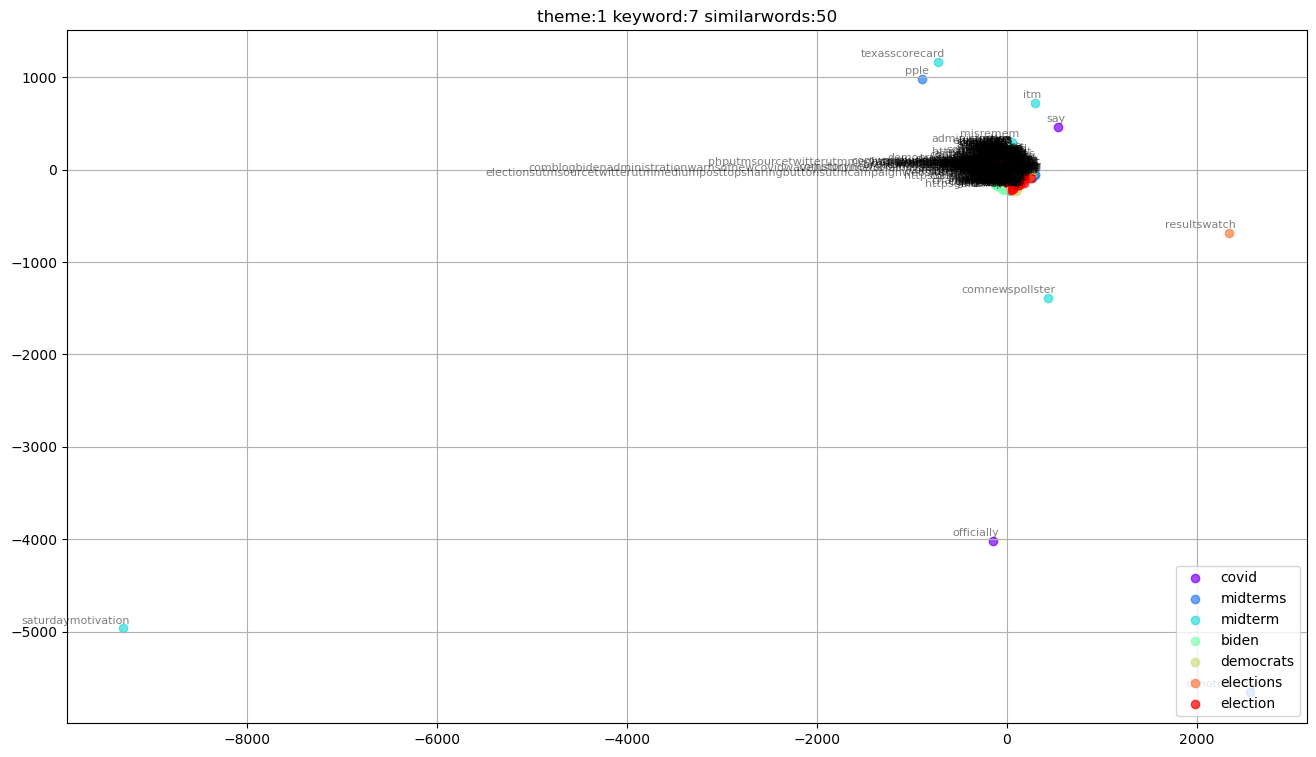

第1个主题 step4:tene and plot over,spend time： 7.413312196731567
第1个主题 analysis data over,spend time： 29.35097908973694
*******************************************************************
第2个主题 extract column data start
第2个主题 extract column data over,spend time： 0.16112351417541504
第2个主题 clean data start
第2个主题 clean data over,spend time： 267.9767882823944
第2个主题 analysis data start
第2个主题 step1:doc2bow and LDA start
第2个主题的单词分布，取权重最高的前7个词: ['covid', 'midterms', 'midterm', 'biden', 'democrats', 'elections', 'days']
第2个主题 step1:doc2bow and LDA over,spend time： 1.640730857849121
第2个主题 step2:save word2vec model start
第2个主题 step2:save word2vec model over,spend time： 19.458572149276733
第2个主题 step3:thematic analysis start
第2个主题词前20个相似词:  [['lol', 'guess', 'something', 'cycle', 'happen', 'scamdemic', 'coincidence', 'knowing', 'unleash', 'phony', 'left', 'deadly', 'sounds', 'massive', 'sure', 'begun', 'scary', 'tell', 'early', 'trouble'], ['justification', 'cheating', 'use', 'scare', 'mass', 'insist',

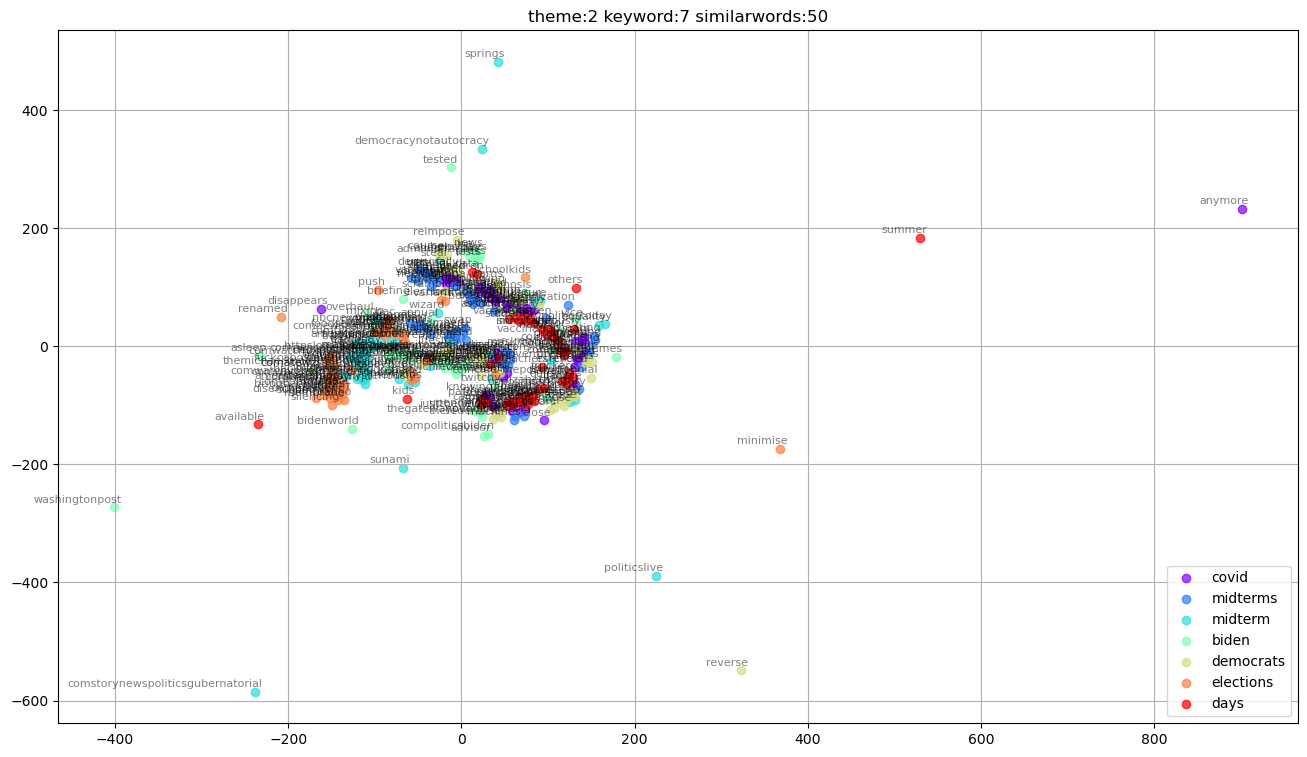

第2个主题 step4:tene and plot over,spend time： 6.839453935623169
第2个主题 analysis data over,spend time： 28.407058238983154
*******************************************************************
第3个主题 extract column data start
第3个主题 extract column data over,spend time： 0.15229368209838867
第3个主题 clean data start
第3个主题 clean data over,spend time： 268.95855736732483
第3个主题 analysis data start
第3个主题 step1:doc2bow and LDA start
第3个主题的单词分布，取权重最高的前7个词: ['covid', 'midterms', 'midterm', 'biden', 'democrats', 'elections', 'days']
第3个主题 step1:doc2bow and LDA over,spend time： 1.6433258056640625
第3个主题 step2:save word2vec model start
第3个主题 step2:save word2vec model over,spend time： 20.1900532245636
第3个主题 step3:thematic analysis start
第3个主题词前20个相似词:  [['slaughter', 'elephant', 'damn', 'theres', 'unfortunately', 'gear', 'incoming', 'coincidence', 'better', 'fjb', 'appear', 'catturd', 'tactic', 'officially', 'laid', 'happen', 'arrived', 'knowing', 'thing', 'covids'], ['extended', 'mass', 'want', 'unregistered', '

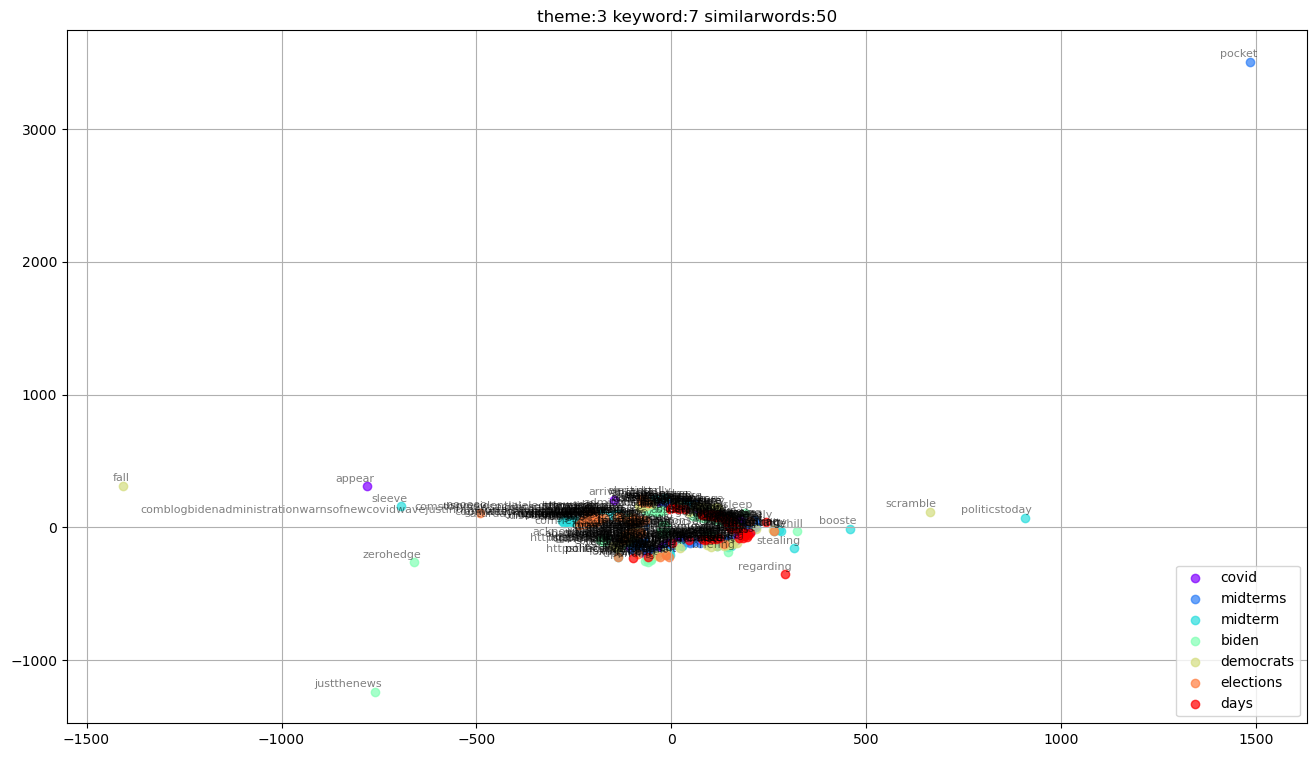

第3个主题 step4:tene and plot over,spend time： 7.708725690841675
第3个主题 analysis data over,spend time： 30.114078521728516
*******************************************************************
第4个主题 extract column data start
第4个主题 extract column data over,spend time： 0.2466444969177246
第4个主题 clean data start
第4个主题 clean data over,spend time： 327.002405166626
第4个主题 analysis data start
第4个主题 step1:doc2bow and LDA start
第4个主题的单词分布，取权重最高的前7个词: ['covid', 'midterms', 'midterm', 'biden', 'elections', 'democrats', 'com']
第4个主题 step1:doc2bow and LDA over,spend time： 2.085299015045166
第4个主题 step2:save word2vec model start
第4个主题 step2:save word2vec model over,spend time： 23.68835139274597
第4个主题 step3:thematic analysis start
第4个主题词前20个相似词:  [['emerge', 'obey', 'ireland', 'season', 'horizon', 'comfox', 'emerges', 'hmm', 'rigging', 'ramps', 'tidal', 'feeble', 'ann', 'mode', 'laying', 'interesting', 'loosing', 'coinciding', 'summer', 'winding'], ['sickening', 'need', 'want', 'rationalize', 'scare', 'fortify'

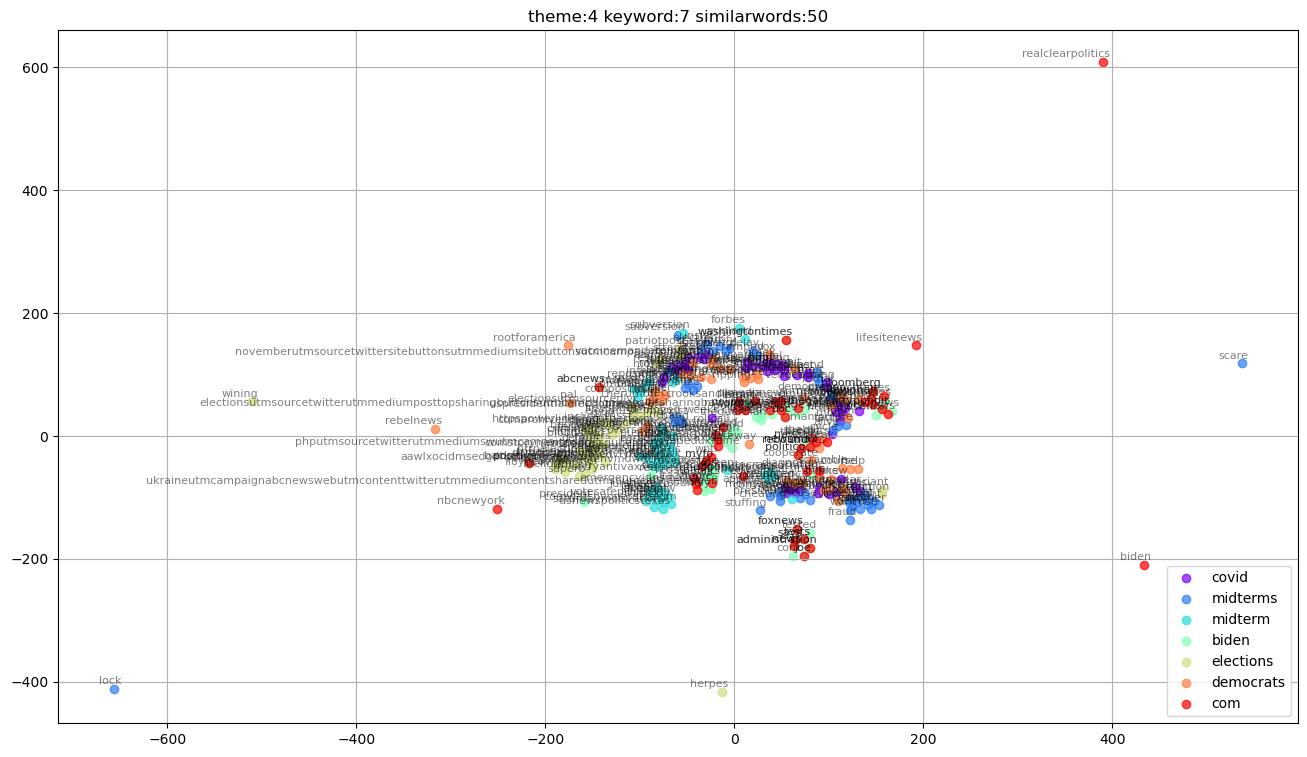

第4个主题 step4:tene and plot over,spend time： 7.0240795612335205
第4个主题 analysis data over,spend time： 33.35561680793762
*******************************************************************
第5个主题 extract column data start
第5个主题 extract column data over,spend time： 0.22801589965820312
第5个主题 clean data start
第5个主题 clean data over,spend time： 341.0511827468872
第5个主题 analysis data start
第5个主题 step1:doc2bow and LDA start
第5个主题的单词分布，取权重最高的前7个词: ['covid', 'midterms', 'midterm', 'biden', 'elections', 'democrats', 'com']
第5个主题 step1:doc2bow and LDA over,spend time： 2.515765905380249
第5个主题 step2:save word2vec model start
第5个主题 step2:save word2vec model over,spend time： 23.58637237548828
第5个主题 step3:thematic analysis start
第5个主题词前20个相似词:  [['proves', 'sorts', 'gettin', 'hesitancy', 'calendar', 'stem', 'hmmmm', 'focal', 'httpsbreitbart', 'waiting', 'quarter', 'abyss', 'fascinating', 'sus', 'clobbered', 'fade', 'managing', 'magical', 'hives', 'primaries'], ['generic', 'schemes', 'fortify', 'lax', 'depen

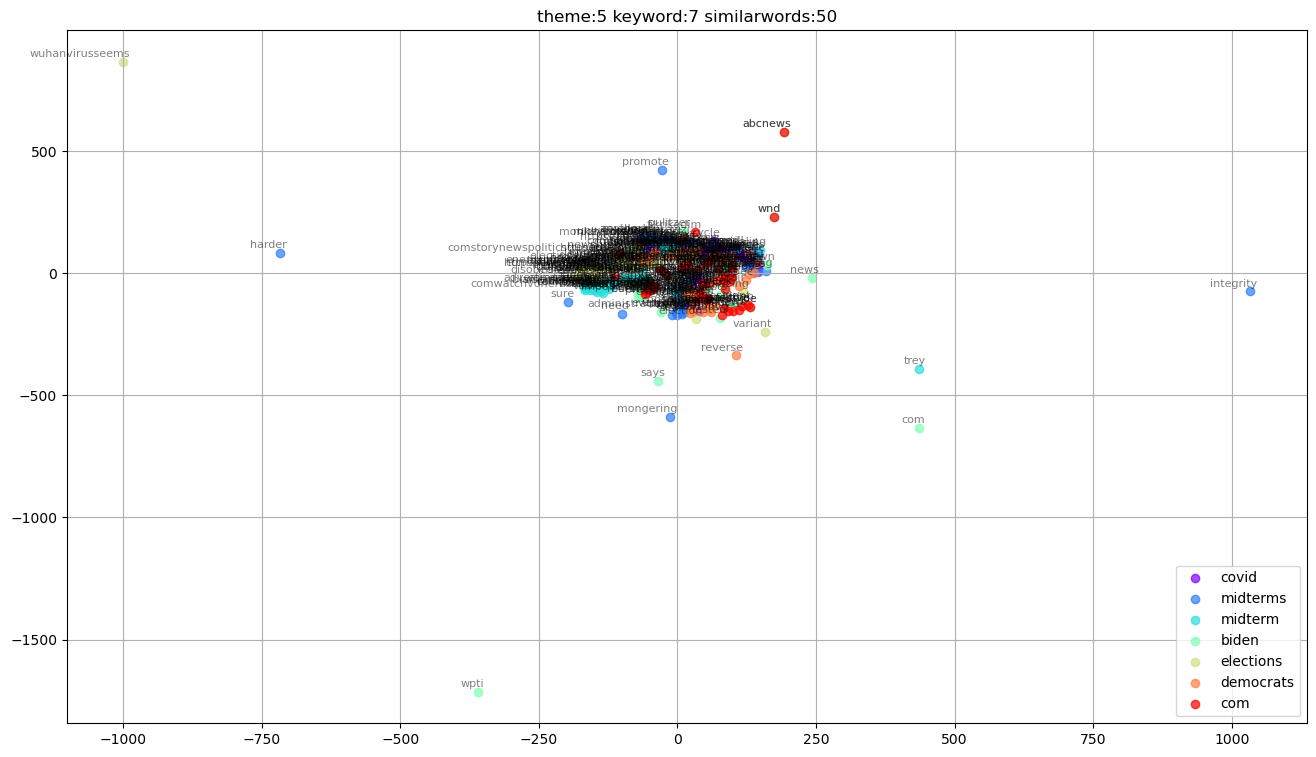

第5个主题 step4:tene and plot over,spend time： 7.068678379058838
第5个主题 analysis data over,spend time： 33.69231176376343
*******************************************************************
第6个主题 extract column data start
第6个主题 extract column data over,spend time： 0.24404120445251465
第6个主题 clean data start
第6个主题 clean data over,spend time： 378.43044447898865
第6个主题 analysis data start
第6个主题 step1:doc2bow and LDA start
第6个主题的单词分布，取权重最高的前7个词: ['covid', 'midterms', 'midterm', 'biden', 'elections', 'pandemic', 'com']
第6个主题 step1:doc2bow and LDA over,spend time： 2.292194128036499
第6个主题 step2:save word2vec model start
第6个主题 step2:save word2vec model over,spend time： 24.541336059570312
第6个主题 step3:thematic analysis start
第6个主题词前20个相似词:  [['hives', 'combines', 'newest', 'reinfect', 'supporternone', 'godzilla', 'delta', 'meddling', 'democracy', 'stealth', 'mepbkzos', 'discovered', 'preserving', 'emerging', 'comcorporate', 'headway', 'coincide', 'watters', 'httpstheblaze', 'walloped'], ['trying', 'need

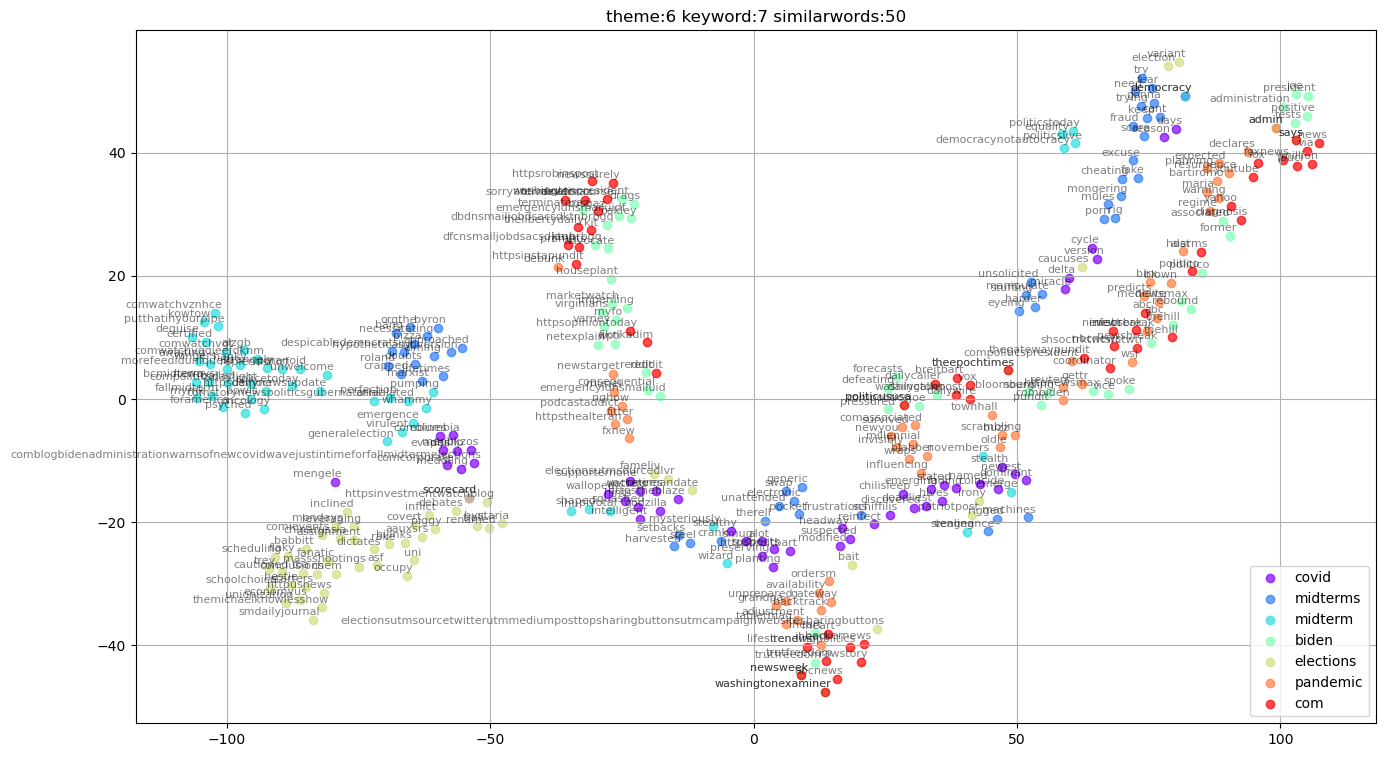

第6个主题 step4:tene and plot over,spend time： 8.785953760147095
第6个主题 analysis data over,spend time： 36.2970871925354
*******************************************************************
用时： 2044.6749305725098


In [8]:
'''
4.能将csv分析
'''
import os
import re
import time
import gensim
import nltk
import numpy as np
from gensim import corpora
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
from nltk import data, pos_tag
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import pandas as pd

# 筛选列数据为数据处理文件
def extract_column_data(file_url, file_handle_url, content_column, column_name):
    print("第%s个主题 extract column data start" % (i + 1))
    start = time.time()

    # 初始化
    try:
        if os.path.isfile(file_handle_url) and os.path.getsize(file_handle_url):#如果有这个文件且不为空就删除
            os.remove(file_handle_url)
    except:
        pass
    # 1.读取数据
    openfile = open(file_url, 'r',encoding='utf-8')
    file_dataframe = pd.read_csv(openfile,encoding='utf-8')
    # 2.筛选数据
    file_dataframe = file_dataframe.loc[:, column_name]#提取列
    file_dataframe.drop_duplicates(subset= [content_column], keep='first', inplace=True)#去重
    # 3.保存数据
    file_dataframe.to_csv(file_handle_url)
    # 4.关闭文件
    openfile.close()

    end = time.time()
    print("第%s个主题 extract column data over,spend time：" % (i + 1), end - start)
# 清洗数据
def clean_data(file_handle_url, stopwords_url, content_column):
    print("第%s个主题 clean data start" % (i + 1))
    start = time.time()

    # 定义正则表达式
    def clean_email_text(text):
        text = text.replace('\n', " ")  # 新行，我们是不需要的
        text = text.lower()  # 转换为小写
        text = re.sub(r"-", " ", text)  # 把 "-" 的两个单词，分开。（比如：july-edu ==> july edu）
        text = re.sub(r"'", " ", text)  # 把 "'" 的两个单词，分开。（比如：It's ==> It s）分开后，s识别为名词了
        text = text.replace('.' or ',' or '(' or ')' or '?', " ")  # 标点符号，没有意义
        text = re.sub(r"\d+/\d+/\d+", "", text)  # 日期，对主体模型没什么意义
        text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text)  # 时间，没意义
        text = re.sub(r"[\w]+@[\.\w]+", "", text)  # 邮件地址，没意义
        text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text)  # 网址，没意义

        # 再把单个字母和两个字母去掉，只留下字母和空格,把特殊字符过滤掉
        pure_text = ''
        for letter in text:
            if letter.isalpha() or letter == ' ':
                pure_text += letter
        text = ' '.join(word for word in pure_text.split() if len(word) > 2) # <class 'str'>

        # 词性标注
        doclist = str(text).strip(' ').strip("'").strip('"').strip('，').split(',') # str转list .strip(' ').strip("'").strip('"').strip('，').split(',')
        doclist = [word for word, tag in pos_tag(doclist) if tag in ["NN", "NNP", "NNS", 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]  # 词性标注，提取名词，doclist:list , 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
        text = "".join(doclist) # list转str

        return text
    # 定义停用词
    def stopword():
        stopwords = [word.strip() for word in open(stopwords_url, 'r', encoding='utf-8').readlines()]
        # 每一封邮件都有星期和月份，这里也把他们过滤掉
        weeks = ['monday', 'mon', 'tuesday', 'tues', 'wednesday', 'wed', 'thursday', 'thur', 'friday', 'fri',
                 'saturday',
                 'sat', 'sunday', 'sun']
        months = ['jan', 'january', 'feb', 'february', 'mar', 'march', 'apr', 'april', 'may', 'jun', 'june', 'jul', \
                  'july', 'aug', 'august', 'sept', 'september', 'oct', 'october', 'nov', 'november', 'dec', 'december']
        stoplist = stopwords + weeks + months + ['am', 'pm']
        return stoplist
    # 1.读取数据
    openfile = open(file_handle_url, 'r', encoding = 'utf-8')
    file_handle_dataframe = pd.read_csv(openfile, encoding = 'utf-8') # <class 'pandas.core.frame.DataFrame'>
    # 2.清洗数据
    docs_series = file_handle_dataframe[content_column].apply(lambda s: clean_email_text(s)) # 选取content_column列进行清洗 <class 'pandas.core.series.Series'>
    docslist = [[word for word in doc.lower().split() if word not in stopword()] for doc in docs_series.values] # 去除停用词 <class 'list'>
    # 3.关闭文件
    openfile.close()

    end = time.time()
    print("第%s个主题 clean data over,spend time：" % (i + 1), end - start)

    return docslist
# 主题分析
def analysis_data(docslist, result_url, keyword_number, similarword_number, needword_number):
    print("第%s个主题 analysis data start" % (i + 1))
    start = time.time()

    # 定义主题词抽取模型(文本转词向量，训练LDA模型，提供主题词)
    def doc2bow_LDA(docslist, file, number, i):
        start0 = time.time()

        print("第%s个主题 step1:doc2bow and LDA start" % (i + 1))
        dictionary = corpora.Dictionary(docslist)
        corpus = [dictionary.doc2bow(text) for text in docslist]
        lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=1)
        result = lda.print_topic(0, topn=number)  # 输出前 number 个主题词及概率
        result = re.compile(r'\b[a-zA-Z]+\b', re.I).findall(result)  # 清洗掉概率
        print("第%s个主题的单词分布，取权重最高的前%d个词: " % (i + 1, number) + str(result))
        file.write("第%s个主题的单词分布，取权重最高的前%d个词" % (i + 1, number) + '\n' + str(result) + '\n')

        end0 = time.time()
        print("第%s个主题 step1:doc2bow and LDA over,spend time：" % (i + 1), end0 - start0)
        return result
    # 定义词向量空间模型
    def word2vec_model(docslist, i):
        start0 = time.time()

        print("第%s个主题 step2:save word2vec model start" % (i + 1))
        train_model = Word2Vec(docslist, vector_size=1024, window=5, min_count=1, workers=4)
        train_model.save(model_url+'%s_MyModel' % i)
        train_model.wv.save_word2vec_format(model_url+'%s_mymodels.txt' % i, binary=False)

        end0 = time.time()
        print("第%s个主题 step2:save word2vec model over,spend time：" % (i + 1), end0 - start0)
    # 定义相似词模型
    def thematic_analysis(file, result, number, i):
        start0 = time.time()

        print("第%s个主题 step3:thematic analysis start" % (i + 1))
        model = Word2Vec.load(model_url+'%s_MyModel' % i)
        keys = result

        word_clusters0 = []
        embedding_clusters = []
        word_clusters = []
        for word in keys:
            embeddings0 = []
            words0 = []
            '''***************************中间这部分是求word用的相似词**************************************'''
            for similar_word, _ in model.wv.most_similar(word, topn=needword_number):  # 根据余弦相似度求相似词
                words0.append(similar_word)  # 末尾添加对象，保存相似词
                embeddings0.append(model.wv[similar_word])  # 保存相似词的词向量
            word_clusters0.append(words0)
            '''****************************************************************************************'''
            embeddings = []
            words = []
            for similar_word, _ in model.wv.most_similar(word, topn=number):  # 根据余弦相似度求相似词
                words.append(similar_word)  # 末尾添加对象，保存相似词
                embeddings.append(model.wv[similar_word])  # 保存相似词的词向量
            embedding_clusters.append(embeddings)
            word_clusters.append(words)

        print("第%s个主题词前%d个相似词: " % ((i+1),needword_number),word_clusters0)
        file.write('\n' + str(word_clusters0))

        end0 = time.time()
        print("第%s个主题 step3:thematic analysis over,spend time：" % (i + 1), end0 - start0)
        return word_clusters, embedding_clusters
    # 定义降维可视化模型
    def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
        start0 = time.time()

        print("第%s个主题 step4:tene and plot start" % (i + 1))
        embedding_clusters = np.array(embedding_clusters)  # 数据类型为多维数组
        n, m, k = embedding_clusters.shape  # 获取三维数组 n*m*k ,k个组，每组有n行m列
        tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32,
                                learning_rate=1000,
                                min_grad_norm=1E-4)  # tsne初始化。perplexity:浮点型，默认30，不敏感, n_components:空间维度，默认为2, init:pca比random初始化稳定, n_iter:优化的最大迭代次数，至少应该200, random_state:伪随机数发生器种子控制
        embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m,
                                                                                                                  2)

        plt.figure(figsize=(16, 9))
        colors = cm.rainbow(np.linspace(0, 1, len(labels)))
        for label, embeddings, words, color in zip(labels, embeddings_en_2d, word_clusters, colors):
            x = embeddings[:, 0]
            y = embeddings[:, 1]
            plt.scatter(x, y, c=color, alpha=a, label=label)
            for j, word in enumerate(words):
                plt.annotate(word, alpha=0.5, xy=(x[j], y[j]), xytext=(5, 2),
                             textcoords='offset points', ha='right', va='bottom', size=8)
        plt.legend(loc=4)
        plt.title(title)
        plt.grid(True)
        if filename:
            plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
        plt.show()

        end0 = time.time()
        print("第%s个主题 step4:tene and plot over,spend time：" % (i + 1), end0 - start0)

    # 初始化
    result = []
    with open(result_url, 'w', encoding='utf-8') as file:#有时清空文本，没有时创建文本
        file.truncate(0)
        file.close()
    # 1.读取数据
    file = open(result_url, 'w', encoding='utf-8')
    # 2.主题分析
    result = doc2bow_LDA(docslist, file, keyword_number, i) # 词向量化并选出前 keyword_number 主题词
    word2vec_model(docslist, i) # 保存模型
    word_clusters, embedding_clusters = thematic_analysis(file, result, similarword_number, i) # 余弦相似度选出前 similarword_number 个词
    tsne_plot_similar_words('theme:%s keyword:%d similarwords:%d' % ((i+1), keyword_number, similarword_number), result, embedding_clusters, word_clusters, 0.7, model_url+'%s.%d.%d.png' % (i, keyword_number,similarword_number))
    # 3.关闭文件
    file.close()

    end = time.time()
    print("第%s个主题 analysis data over,spend time：" % (i + 1), end - start)

#传参
folderurl = '/kaggle/working/midterm_COVID/'


keyword_number = 7  # 主题词个数
similarword_number = 50  # 需要plt相似词个数
needword_number = 20 # 需要write相似词个数

stopwords_url = '/kaggle/input/stopwords/stopwords.txt'  # 停用词
model_url = folderurl
column_name = ['UserName', 'Embedded_text']  # 需要提取列的列名
content_column = 'Embedded_text'  # 关注的内容列

if __name__ == '__main__':
    startall = time.time()

    # 初始化
    matplotlib_axes_logger.setLevel('ERROR')
    data.path.append(r'/root/nltk_data')
    warnings.filterwarnings("ignore")

    for i in range(6):
        # 传参
        file_url = folderurl + '%s%s.csv' %(i,i)  # 原始文件
        file_handle_url = folderurl + '%s%s%s_file_handle.csv' %(i,i,i)  # 筛选列后的文件
        result_url = folderurl + '%s%s%s%s_thematic_analysis_result.txt' %(i,i,i,i)  # 主题词

        # 筛选列数据为数据处理文件
        extract_column_data(file_url, file_handle_url, content_column, column_name)
        # step2:清洗数据
        docslist = clean_data(file_handle_url, stopwords_url, content_column)
        # step3:主题分析
        analysis_data(docslist, result_url, keyword_number, similarword_number, needword_number)
        print('*******************************************************************')
    endall = time.time()
    print("用时：", endall - startall)

In [9]:
mkdir /kaggle/working/midterm_COVID/all

第1个主题 extract column data start
第1个主题 extract column data over,spend time： 0.42976999282836914
第1个主题 clean data start
第1个主题 clean data over,spend time： 409.45380759239197
第1个主题 analysis data start
第1个主题 step1:doc2bow and LDA start
第1个主题的单词分布，取权重最高的前7个词: ['covid', 'midterms', 'midterm', 'biden', 'elections', 'democrats', 'pandemic']
第1个主题 step1:doc2bow and LDA over,spend time： 2.5367207527160645
第1个主题 step2:save word2vec model start
第1个主题 step2:save word2vec model over,spend time： 32.909425020217896
第1个主题 step3:thematic analysis start
第1个主题词前20个相似词:  [['year', 'crucial', 'arrived', 'hyping', 'invisibly', 'leftelite', 'kronews', 'suspects', 'lmv', 'godzilla', 'resurface', 'faridjalali', 'midnight', 'electionwiz', 'schiffilis', 'choosing', 'emerge', 'waiting', 'glide', 'httpspatriotpost'], ['monkey', 'pox', 'promote', 'mentions', 'trying', 'use', 'excuse', 'universalhealthcare', 'scapegoat', 'orgthe', 'bang', 'postal', 'incase', 'httpsisrapundit', 'covet', 'reliable', 'scare', 'vengeance'

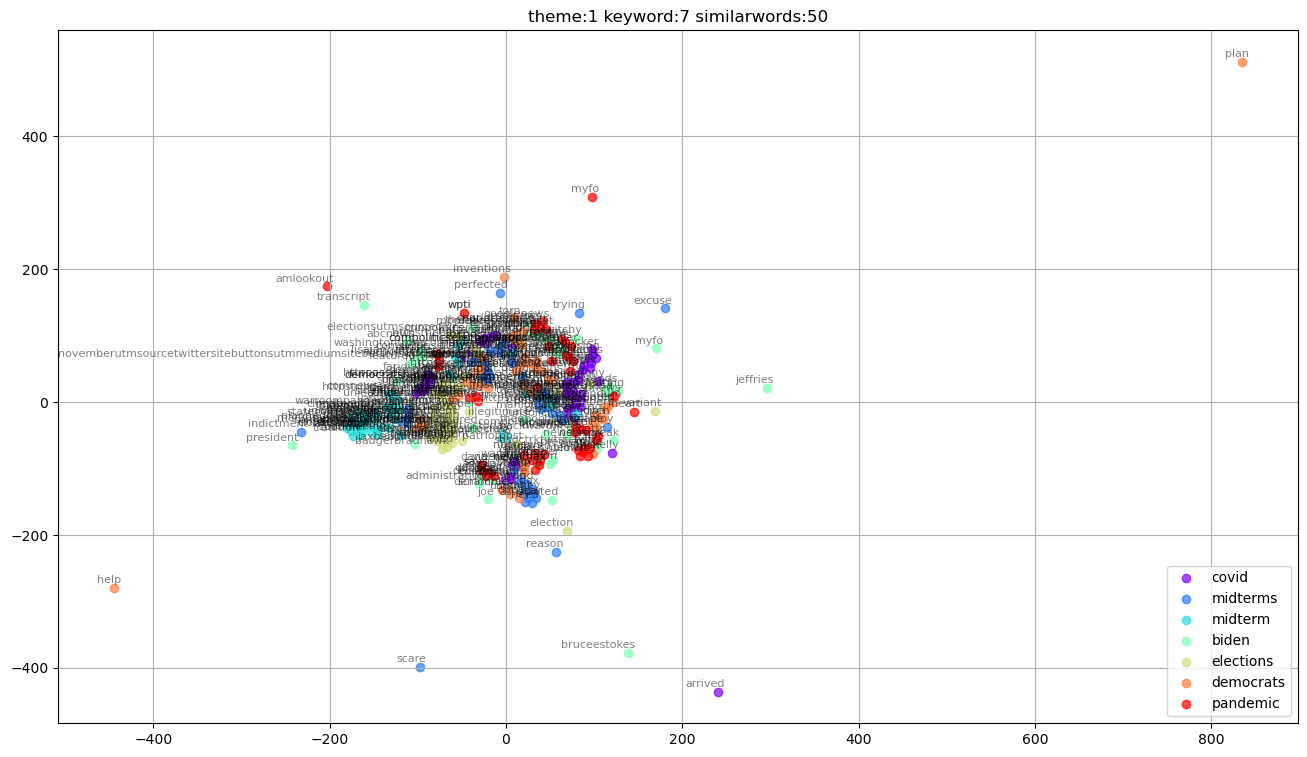

第1个主题 step4:tene and plot over,spend time： 8.410030841827393
第1个主题 analysis data over,spend time： 44.71542572975159
*******************************************************************
用时： 454.6370108127594


In [10]:
'''
4.1 能将csv分析了，用于直接对全部csv分析
'''
import os
import re
import time
import gensim
import nltk
import numpy as np
from gensim import corpora
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
from nltk import data, pos_tag
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import pandas as pd

# 筛选列数据为数据处理文件
def extract_column_data(file_url, file_handle_url, content_column, column_name):
    print("第%s个主题 extract column data start" % (i + 1))
    start = time.time()

    # 初始化
    try:
        if os.path.isfile(file_handle_url) and os.path.getsize(file_handle_url):#如果有这个文件且不为空就删除
            os.remove(file_handle_url)
    except:
        pass
    # 1.读取数据
    openfile = open(file_url, 'r', encoding='utf-8')
    # file_dataframe = pd.read_csv(openfile,encoding='utf-8')
    file_dataframe = pd.read_csv(openfile, encoding='utf-8')
    # 2.筛选数据
    file_dataframe = file_dataframe.loc[:, column_name]#提取列
    file_dataframe.drop_duplicates(subset= [content_column], keep='first', inplace=True)#去重
    # 3.保存数据
    file_dataframe.to_csv(file_handle_url)
    # 4.关闭文件
    openfile.close()

    end = time.time()
    print("第%s个主题 extract column data over,spend time：" % (i + 1), end - start)
# 清洗数据
def clean_data(file_handle_url, stopwords_url, content_column):
    print("第%s个主题 clean data start" % (i + 1))
    start = time.time()

    # 定义正则表达式
    def clean_email_text(text):
        text = text.replace('\n', " ")  # 新行，我们是不需要的
        text = text.lower()  # 转换为小写
        text = re.sub(r"-", " ", text)  # 把 "-" 的两个单词，分开。（比如：july-edu ==> july edu）
        text = re.sub(r"'", " ", text)  # 把 "'" 的两个单词，分开。（比如：It's ==> It s）分开后，s识别为名词了
        text = text.replace('.' or ',' or '(' or ')' or '?', " ")  # 标点符号，没有意义
        text = re.sub(r"\d+/\d+/\d+", "", text)  # 日期，对主体模型没什么意义
        text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text)  # 时间，没意义
        text = re.sub(r"[\w]+@[\.\w]+", "", text)  # 邮件地址，没意义
        text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text)  # 网址，没意义
        text = re.sub(r"[\u4E00-\u9FA5]+", "", text)
        text = re.sub(r"\d?.\d", "", text) # 删除2.1这类数字
        text = re.sub(r"\d","",text) # 删除数字

        # 再把单个字母和两个字母去掉，只留下字母和空格,把特殊字符过滤掉
        pure_text = ''
        for letter in text:
            if letter.isalpha() or letter == ' ':
                pure_text += letter
        text = ' '.join(word for word in pure_text.split() if len(word) > 2) # <class 'str'>

        # 词性标注
        doclist = str(text).strip(' ').strip("'").strip('"').strip('，').split(',') # str转list .strip(' ').strip("'").strip('"').strip('，').split(',')
        doclist = [word for word, tag in pos_tag(doclist) if tag in ["NN", "NNP", "NNS", 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]  # 词性标注，提取名词，doclist:list , 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
        text = "".join(doclist) # list转str

        return text
    # 定义停用词
    def stopword():
        stopwords = [word.strip() for word in open(stopwords_url, 'r', encoding='utf-8').readlines()]
        # 每一封邮件都有星期和月份，这里也把他们过滤掉
        weeks = ['monday', 'mon', 'tuesday', 'tues', 'wednesday', 'wed', 'thursday', 'thur', 'friday', 'fri',
                 'saturday',
                 'sat', 'sunday', 'sun']
        months = ['jan', 'january', 'feb', 'february', 'mar', 'march', 'apr', 'april', 'may', 'jun', 'june', 'jul', \
                  'july', 'aug', 'august', 'sept', 'september', 'oct', 'october', 'nov', 'november', 'dec', 'december']
        stoplist = stopwords + weeks + months + ['am', 'pm']
        return stoplist
    # 1.读取数据
    openfile = open(file_handle_url, 'r', encoding = 'utf-8')
    file_handle_dataframe = pd.read_csv(openfile, encoding = 'utf-8') # <class 'pandas.core.frame.DataFrame'>
    # 2.清洗数据
    docs_series = file_handle_dataframe[content_column].apply(lambda s: clean_email_text(s)) # 选取content_column列进行清洗 <class 'pandas.core.series.Series'>
    docslist = [[word for word in doc.lower().split() if word not in stopword()] for doc in docs_series.values] # 去除停用词 <class 'list'>
    # 3.关闭文件
    openfile.close()

    end = time.time()
    print("第%s个主题 clean data over,spend time：" % (i + 1), end - start)

    return docslist
# 主题分析
def analysis_data(docslist, result_url, keyword_number, similarword_number, needword_number):
    print("第%s个主题 analysis data start" % (i + 1))
    start = time.time()

    # 定义主题词抽取模型(文本转词向量，训练LDA模型，提供主题词)
    def doc2bow_LDA(docslist, file, number, i):
        start0 = time.time()

        print("第%s个主题 step1:doc2bow and LDA start" % (i + 1))
        dictionary = corpora.Dictionary(docslist)
        corpus = [dictionary.doc2bow(text) for text in docslist]
        lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=1)
        result = lda.print_topic(0, topn=number)  # 输出前 number 个主题词及概率
        result = re.compile(r'\b[a-zA-Z]+\b', re.I).findall(result)  # 清洗掉概率
        print("第%s个主题的单词分布，取权重最高的前%d个词: " % (i + 1, number) + str(result))
        file.write("第%s个主题的单词分布，取权重最高的前%d个词" % (i + 1, number) + '\n' + str(result) + '\n')

        end0 = time.time()
        print("第%s个主题 step1:doc2bow and LDA over,spend time：" % (i + 1), end0 - start0)
        return result
    # 定义词向量空间模型
    def word2vec_model(docslist, i):
        start0 = time.time()

        print("第%s个主题 step2:save word2vec model start" % (i + 1))
        train_model = Word2Vec(docslist, vector_size=1024, window=5, min_count=1, workers=4)
        train_model.save(model_url+'%s_MyModel' % i)
        train_model.wv.save_word2vec_format(model_url+'%s_mymodels.txt' % i, binary=False)

        end0 = time.time()
        print("第%s个主题 step2:save word2vec model over,spend time：" % (i + 1), end0 - start0)
    # 定义相似词模型
    def thematic_analysis(file, result, number, i):
        start0 = time.time()

        print("第%s个主题 step3:thematic analysis start" % (i + 1))
        model = Word2Vec.load(model_url+'%s_MyModel' % i)
        keys = result

        word_clusters0 = []
        embedding_clusters = []
        word_clusters = []
        for word in keys:
            embeddings0 = []
            words0 = []
            '''***************************中间这部分是求word用的相似词**************************************'''
            for similar_word, _ in model.wv.most_similar(word, topn=needword_number):  # 根据余弦相似度求相似词
                words0.append(similar_word)  # 末尾添加对象，保存相似词
                embeddings0.append(model.wv[similar_word])  # 保存相似词的词向量
            word_clusters0.append(words0)
            '''****************************************************************************************'''
            embeddings = []
            words = []
            for similar_word, _ in model.wv.most_similar(word, topn=number):  # 根据余弦相似度求相似词
                words.append(similar_word)  # 末尾添加对象，保存相似词
                embeddings.append(model.wv[similar_word])  # 保存相似词的词向量
            embedding_clusters.append(embeddings)
            word_clusters.append(words)

        print("第%s个主题词前%d个相似词: " % ((i+1),needword_number),word_clusters0)
        file.write('\n' + str(word_clusters0))

        end0 = time.time()
        print("第%s个主题 step3:thematic analysis over,spend time：" % (i + 1), end0 - start0)
        return word_clusters, embedding_clusters
    # 定义降维可视化模型
    def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
        start0 = time.time()

        print("第%s个主题 step4:tene and plot start" % (i + 1))
        embedding_clusters = np.array(embedding_clusters)  # 数据类型为多维数组
        n, m, k = embedding_clusters.shape  # 获取三维数组 n*m*k ,k个组，每组有n行m列
        tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32,
                                learning_rate=1000,
                                min_grad_norm=1E-4)  # tsne初始化。perplexity:浮点型，默认30，不敏感, n_components:空间维度，默认为2, init:pca比random初始化稳定, n_iter:优化的最大迭代次数，至少应该200, random_state:伪随机数发生器种子控制
        embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m,
                                                                                                                  2)

        plt.figure(figsize=(16, 9))
        colors = cm.rainbow(np.linspace(0, 1, len(labels)))
        for label, embeddings, words, color in zip(labels, embeddings_en_2d, word_clusters, colors):
            x = embeddings[:, 0]
            y = embeddings[:, 1]
            plt.scatter(x, y, c=color, alpha=a, label=label)
            for j, word in enumerate(words):
                plt.annotate(word, alpha=0.5, xy=(x[j], y[j]), xytext=(5, 2),
                             textcoords='offset points', ha='right', va='bottom', size=8)
        plt.legend(loc=4)
        plt.title(title)
        plt.grid(True)
        if filename:
            plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
        plt.show()

        end0 = time.time()
        print("第%s个主题 step4:tene and plot over,spend time：" % (i + 1), end0 - start0)

    # 初始化
    result = []
    with open(result_url, 'w', encoding='utf-8') as file:#有时清空文本，没有时创建文本
        file.truncate(0)
        file.close()
    # 1.读取数据
    file = open(result_url, 'w', encoding='utf-8')
    # 2.主题分析
    result = doc2bow_LDA(docslist, file, keyword_number, i) # 词向量化并选出前 keyword_number 主题词
    word2vec_model(docslist, i) # 保存模型
    word_clusters, embedding_clusters = thematic_analysis(file, result, similarword_number, i) # 余弦相似度选出前 similarword_number 个词
    tsne_plot_similar_words('theme:%s keyword:%d similarwords:%d' % ((i+1), keyword_number, similarword_number), result, embedding_clusters, word_clusters, 0.7, model_url+'%s.%d.%d.png' % (i, keyword_number,similarword_number))
    # 3.关闭文件
    file.close()

    end = time.time()
    print("第%s个主题 analysis data over,spend time：" % (i + 1), end - start)

#传参

folderurl = '/kaggle/working/midterm_COVID/all/'
readcsv = '/kaggle/input/midterm-covid/221012_midterm_COVID_2022-01-01_2022-10-10.csv' # (17690, 9)

keyword_number = 7  # 主题词个数
similarword_number = 50  # 需要plt相似词个数
needword_number = 20 # 需要write相似词个数
stopwords_url = '/kaggle/input/stopwords/stopwords.txt'  # 停用词
file_url = readcsv
model_url = folderurl
column_name = ['UserName', 'Embedded_text']  # 需要提取列的列名
content_column = 'Embedded_text'  # 关注的内容列

if __name__ == '__main__':
    startall = time.time()

    # 初始化
    matplotlib_axes_logger.setLevel('ERROR')
    data.path.append(r'/root/nltk_data')
    warnings.filterwarnings("ignore")

    for i in range(1):
        # 传参
        # file_url = '../data/221006_midterm_election_taiwan_2022-01-01_2022-10-01.csv'
        file_handle_url = folderurl + 'file_handle.csv'  # 筛选列后的文件
        result_url = folderurl + 'thematic_analysis_result.txt'  # 主题词
        # file_url = '../result/midterm_election_communist_party/all/%s%s.csv' %(i,i)  # 原始文件
        # file_handle_url = '../result/midterm_election_communist_party/all/%s%s%s_file_handle.csv' %(i,i,i)  # 筛选列后的文件
        # result_url = '../result/midterm_election_communist_party/all/%s%s%s%s_thematic_analysis_result.txt' %(i,i,i,i)  # 主题词

        # 筛选列数据为数据处理文件
        extract_column_data(file_url, file_handle_url, content_column, column_name)
        # step2:清洗数据
        docslist = clean_data(file_handle_url, stopwords_url, content_column)
        # step3:主题分析
        analysis_data(docslist, result_url, keyword_number, similarword_number, needword_number)
        print('*******************************************************************')
    endall = time.time()
    print("用时：", endall - startall)

In [11]:
'''
5.能对人名出现次数进行排序了
'''
import os
import numpy as np
import pandas as pd
import time

# 传参
folderurl = '/kaggle/working/midterm_COVID/all/'
readcsv = '/kaggle/input/midterm-covid/221012_midterm_COVID_2022-01-01_2022-10-10.csv' # (17690, 9)

youwant = 'UserName'
writetxt = folderurl + 'num2username.txt'
numnum = 2 # 需要重复几次以上才导出

if __name__ == '__main__':
    start = time.time()

    # 1.读取文件
    tx = open(readcsv, 'r', encoding='utf-8')
    df = pd.read_csv(tx, encoding='utf-8')
    tx.close()

    # 2.选择要排序的列名
    df.drop_duplicates(subset='Embedded_text', keep='first', inplace=True) # 去重
    Cname = df[youwant].values
    num = np.array(range(0, len(Cname)))  # 开辟空间用于记录每个人名重复出现次数
    space = range(0, len(Cname))
    space = pd.DataFrame(space, columns=['UserName'])

    # 3.记录重复次数
    for i in range(len(Cname)):
        k = 0  # 记录次数
        for j in range(len(Cname)):
            if (Cname[i] == Cname[j]):
                space['UserName'][i] = Cname[j]
                k = k + 1
            else:
                k = k
        num[i] = k

    # 4.组合成一个dataframe
    num = pd.DataFrame(data=num, columns=['num'])
    frame = [space, num]  # concat进行两个dataframe合并
    result = pd.concat(frame, axis=1)  # axis=1为向右连接，  =0 为向下连接
    result = result.drop_duplicates('UserName',keep='first')  # 去除重复行
    result = result.sort_values(by='num', ascending=False) # 默认升序，降序补ascending=False
    result = result.reset_index(drop=True) # 修改索引 为升序，即最左边的01234。 <class 'pandas.core.frame.DataFrame'>
    print(result)


    # 4.写入数据
    if not os.path.exists(writetxt):
        os.system(r"touch {}".format(os.path))  # 调用系统命令行来创建文件
    with open(writetxt, 'w', encoding='utf-8') as file:  # 有时清空文本
        file.truncate(0)
        file.close()
    txt = open(writetxt, 'w')
    aa = result['num'] # <class 'pandas.core.series.Series'>
    bb = result['UserName']
    for i in range(len(aa)):
        if int(aa[i] > numnum):
            print('UserName:', bb[i], ' , ', 'num:', aa[i])# 查看写入内容
            txt.write('UserName: ' + str(bb[i]) + ' , ' + 'num: ' + str(aa[i]) + '\n')
    txt.close()

    print("finish")
    end = time.time()
    print("用时：", end - start)

               UserName  num
0              @QuealyJ  213
1            @ElectNPol   74
2       @DemocratVideos   71
3             @LostDiva   60
4       @myrabatchelder   39
...                 ...  ...
13572        @SeanDowey    1
13573      @HyperNova85    1
13574  @AuthorDavidSto1    1
13575  @William54365597    1
13576    @alt_brainnews    1

[13577 rows x 2 columns]
UserName: @QuealyJ  ,  num: 213
UserName: @ElectNPol  ,  num: 74
UserName: @DemocratVideos  ,  num: 71
UserName: @LostDiva  ,  num: 60
UserName: @myrabatchelder  ,  num: 39
UserName: @thomvolz  ,  num: 32
UserName: @jhosker01  ,  num: 27
UserName: @chrisoldcorn  ,  num: 25
UserName: @jasonorton420  ,  num: 19
UserName: @br0wnmcse  ,  num: 17
UserName: @TheMAGAWatch  ,  num: 16
UserName: @bfry1981  ,  num: 15
UserName: @cbinflux  ,  num: 14
UserName: @MiguelD05144897  ,  num: 13
UserName: @rudtmarg  ,  num: 13
UserName: @DerekCBeland  ,  num: 12
UserName: @ladyozma  ,  num: 12
UserName: @RonNjPoetry  ,  num: 12
UserName

sh: 1: Syntax error: end of file unexpected


In [12]:
'''
6.能根据人名抽取文章
'''
import re
import time
import pandas as pd

# 传参

folderurl = '/kaggle/working/midterm_COVID/all/'
readcsv = '/kaggle/input/midterm-covid/221012_midterm_COVID_2022-01-01_2022-10-10.csv' # (17690, 9)

readtxt = folderurl + 'num2username.txt'
youwant = ['UserName','Embedded_text']

if __name__ == '__main__':
    start = time.time()

    #初始化
    UserNametxt = []
    num = []
    matchnum = 0 # 匹配成功次数
    repeatnum = 0 # 用户名重复次数
    flag = 0
    word = []
    wordname = []

    # 1.txt中获取UserName和num列表
    txt = open(readtxt,'r', encoding='utf-8')
    aa = txt.readlines() # list, len = 1
    txt.close()
    for i in range(len(aa)):
        bb = aa[i] # str, len = 54
        # print(bb)
        UserNametxt.append(re.findall(r'(?<=UserName: ).*?(?= , )', bb)) # <class 'list'>
        # print('UserName:', UserNametxt[i])
        num.append(re.findall(r'(?<=num: ).*?(?=\s)', bb)) # <class 'list'>
        # print('num: ', num[i])

    # 2.csv中获取语句
    tx = open(readcsv, 'r', encoding='utf-8')
    df = pd.read_csv(tx, encoding='utf-8')
    tx.close()
    df.drop_duplicates(subset='Embedded_text', keep='first', inplace=True)  # 去重
    UserNamecsv = df[youwant[0]].values # <class 'pandas.core.series.Series'> len = 15
    Embedded_textcsv = df[youwant[1]].values

    # 3.根据用户名筛选数据
    for j in range(len(UserNametxt)):# len = 15
        # 判断用户名是否相同，相同则导出word
        for k in range(len(UserNamecsv)): # len = 1
            if UserNamecsv[k] in UserNametxt[j]:
                # print(UserNametxt[j])
                flag = 1
                matchnum += 1
                # 正则处理
                ee = Embedded_textcsv[k].replace('回复', "")  # 删除“回复”
                ee = re.sub(r"@.*?\s", "", ee)  # 删除@后面的人名
                ee = re.sub(r"[\u4E00-\u9FA5]+", "", ee)  # 删除中文，\u4E00-\u9FA5\\s的话s不见了
                ee = re.sub(r"\n", " ", ee)  # 删除换行
                ee = ee.rstrip().lstrip()  # 删除句首和句尾的字符，默认删除空白符和换行符
                ee = ee + '\n' # 补充换行
                # 保存到word
                word.append(ee)
                wordname = UserNametxt[j]
        if flag == 1:
            print(UserNametxt[j])
            print(word)
            word = []
            flag = 0

    print("finish")
    end = time.time()
    print("用时：", end - start)

['@QuealyJ']
['As of 5:20am EDT 01/01/22  825,536 Dead Americans. 1,197 died from Covid-19 in the past 24 hrs 1918 Spanish Flu deaths 675,000 54,743,993 confirmed US cases. 505,383,863 Vaccine Doses Given.  78 days until Spring 106 days until Easter 171 days until Summer 311 days until midterms\n', 'As of 6:20am EDT 01/02/22  825,819 Dead Americans. 283 died from Covid-19 in the past 25 hrs. 1918 Spanish Flu deaths 675,000 54,860,424 confirmed US cases. 505,411,600 Vaccine Doses Given.  77 days until Spring 105 days until Easter 170 days until Summer 310 days until midterms.\n', 'As of 6:20am EDT 01/03/22  826,065 Dead Americans. 246 died from Covid-19 in the past 24 hrs. 1918 Spanish Flu deaths 675,000. 55,114,128 confirmed US cases. 505,424,829 Vaccine Doses Given.  76 days until Spring 104 days until Easter 169 days until Summer 309 days until midterms\n', 'As of 5:20am EDT 01/04/22  827,749 Dead Americans. 1,684 died from Covid-19 in the past 23 hrs 1918 Spanish Flu deaths 675,000 

In [13]:
'''
7.实现查看csv的shape功能
'''
import time
import pandas as pd

# 传参
file = '/kaggle/working/midterm_COVID/all/file_handle.csv' #(17290, 3)

if __name__ == '__main__':
    start = time.time()

    openfile = open(file, 'r', encoding='utf-8')
    file_dataframe = pd.read_csv(openfile, encoding='utf-8')
    print(file_dataframe.shape)

    print("finish")
    end = time.time()
    print("用时：", end - start)

(17290, 3)
finish
用时： 0.09168720245361328
